In [ ]:
import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
import json
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
#import keras_metrics as km
 
import matplotlib.pyplot as plt

In [ ]:
data_dir = "/content/drive/MyDrive/advideos"
img_height , img_width = 64, 64
seq_len = 70


In [ ]:
topics={1:'Restaurant', 2:'Sweets',3:'Snacks',6:'Alcohol',
        8:'Soda',9:'Cars',10:'Electronics',
      17:'Beauty',18:'Health',19:'Clothing',21:'Games and toys'
       ,25:'Travel',26:'Arts'}

In [ ]:
topics_numerate={1:0,2:1,3:2,6:3,8:4,9:5,10:6,17:7,18:8,19:9,21:10,25:11,26:12}

In [ ]:
def frames_extraction(video_path):
    frames_list = []
     
    vidObj = cv2.VideoCapture(video_path)
    count = 1
 
    while count <= seq_len: 
         
        success, image = vidObj.read() 
        if success:
            image = cv2.resize(image, (img_height, img_width))
            frames_list.append(image)
            count += 1
        else:
            print("Defected frame")
            break
 
            
    return frames_list

In [ ]:
def create_data(input_dir,cat_data):
    X = []
    Y = []
    i=0 
    counts={}
    files_list = os.listdir(input_dir)
    for f in files_list:
      i+=1
      print(i)
      name=f.split(".")[0]
      cat=cat_data[name]
      if cat in topics.keys():
        frames = frames_extraction(os.path.join(input_dir, f))
        if len(frames) == seq_len:
            counts[cat] = counts.get(cat, 0) + 1
            X.append(frames)
            Y.append(cat)
    X = np.asarray(X)
    Y = np.asarray(Y)
    return X, Y
  
    

In [ ]:
file_path='/content/drive/MyDrive/Colab Notebooks/video_Topics_clean.json'


In [ ]:
with open(file_path) as json_file:
    data = json.load(json_file)

In [ ]:
X,Y=create_data(data_dir,data)

In [ ]:
def create_model_ConvLSTM():
  model = Sequential()
  model.add(ConvLSTM2D(filters = 64, kernel_size = (3, 3), return_sequences = False, data_format = "channels_last", 
                       input_shape = (seq_len, img_height, img_width, 3)))
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(Dense(256, activation="relu"))
  model.add(Dropout(0.3))
  model.add(Dense(13, activation = "softmax"))
  opt = keras.optimizers.SGD(lr=0.001)
  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])
  return model

In [ ]:
def create_model_cnn_lstm():
  model = Sequential()
  model.add(TimeDistributed(Conv2D(filters=64, kernel_size=3, activation='relu'), 
                            input_shape = (seq_len, img_height, img_width, 3)))
  model.add(TimeDistributed(Conv2D(filters=64, kernel_size=3, activation='relu')))
  model.add(TimeDistributed(Dropout(0.5)))
  model.add(TimeDistributed(MaxPooling2D(pool_size=2)))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(100))
  model.add(Dropout(0.5))
  model.add(Dense(100, activation='relu'))
  model.add(Dense(13, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [ ]:
def create_model_cnn_lstm2():
  model = Sequential()
  model.add(TimeDistributed(Conv2D(filters=64, kernel_size=3, activation='relu'),
                            input_shape = (seq_len, img_height, img_width, 3)))
  model.add(TimeDistributed(Conv2D(filters=64, kernel_size=3, activation='relu')))
  model.add(TimeDistributed(Dropout(0.5)))
  model.add(TimeDistributed(MaxPooling2D(pool_size=2)))
  model.add(TimeDistributed(Flatten()))
  model.add(Bidirectional(LSTM(100)))
  model.add(Dropout(0.5))
  model.add(Dense(100, activation='relu'))
  model.add(Dense(13, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [ ]:
def acccuracy_plot(history):
  plt.figure(figsize=(10, 5))
  plt.figure(figsize=(10, 5))
  plt.plot(history.history['accuracy'], label='Точность на обучающем наборе')
  plt.plot(history.history['val_accuracy'], label='Точность на проверочном наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Точность')
  plt.legend()
  plt.show()

In [ ]:
X,Y=create_data(data_dir,data)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, shuffle=True, random_state=0)


In [ ]:
y_train1,y_test1=[],[]
for y in y_train:
  y_train1.append(topics_numerate[y])
for y in y_test:
  y_test1.append(topics_numerate[y])

In [ ]:
y_train=y_train1
y_test=y_test1

In [ ]:
from tensorflow.keras.utils import to_categorical
y_train_oh = to_categorical(y_train, 13)
y_test_oh = to_categorical(y_test, 13)

cnn_lstm

In [ ]:
model=create_model_cnn_lstm()

In [ ]:
from keras.utils.vis_utils import plot_model

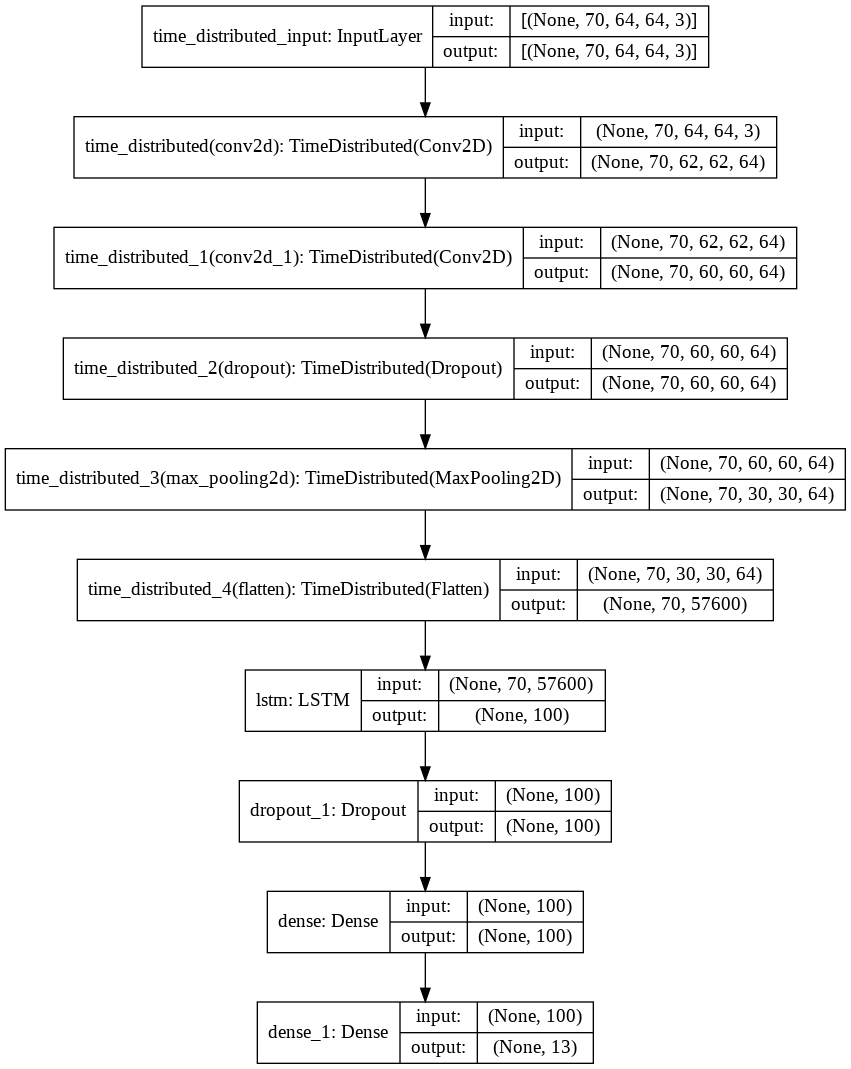

In [ ]:
plot_model(model, to_file='modelcl_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(x = X_train, y = y_train_oh, epochs=25, batch_size = 8 , shuffle=True, validation_split=0.2,callbacks=callbacks)

In [ ]:
model_path='/content/drive/MyDrive/Colab Notebooks/model/cnnlstm.h5'

In [ ]:
model.save(model_path)

In [ ]:
your_history_path='/content/drive/MyDrive/Colab Notebooks/model/cnnlstm.json'

In [ ]:
import json
history_dict = history.history
json.dump(history_dict, open(your_history_path, 'w'))

In [ ]:
with open(your_history_path) as json_file:
    data = json.load(json_file)

In [ ]:
model=keras.models.load_model(model_path)

In [2]:
preds=model.predict(X_test)
results1=[]
for row in preds:
  results1.append(np.argmax(row))
from sklearn.metrics import accuracy_score
accuracy_score(y_test, results1)

0.294721995472908

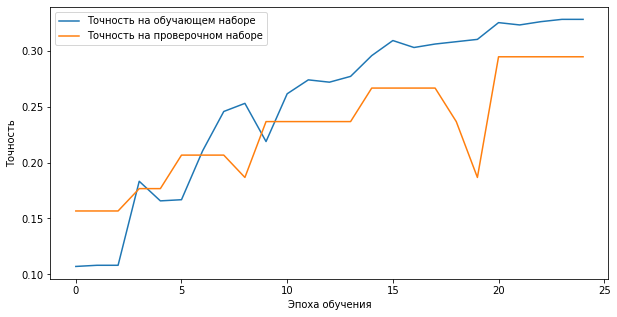

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(data['val_accuracy'], label='Точность на проверочном наборе')
plt.plot(data['accuracy'], label='Точность на обучающем наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Точность')
plt.legend()
plt.show()

Biderectional CNN-LSTM 

In [ ]:
model=create_model_cnn_lstm2()

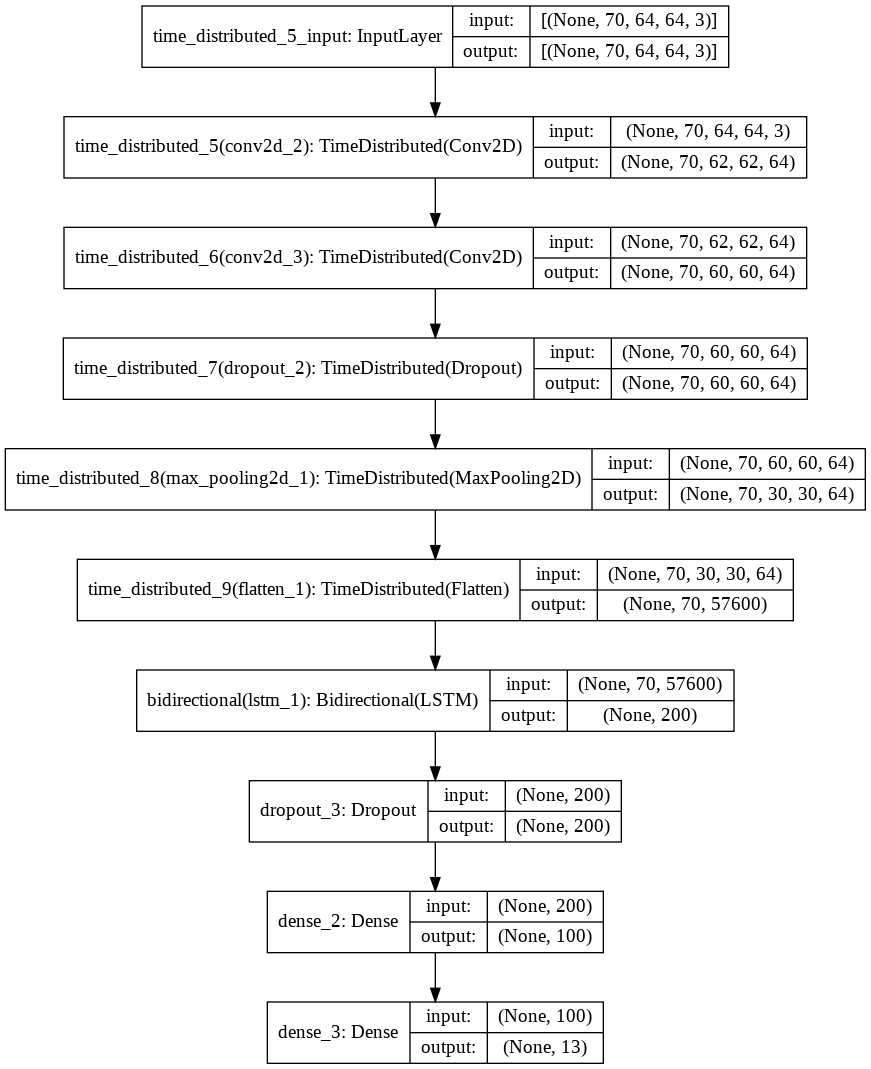

In [ ]:
plot_model(model, to_file='modelcl_plo1t.png', show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(x = X_train, y = y_train_oh, epochs=25, batch_size = 8 , shuffle=True, validation_split=0.2,callbacks=callbacks)

In [ ]:
model_path='/content/drive/MyDrive/Colab Notebooks/model/cnnlstm2.h5'

In [ ]:
model.save(model_path)

In [ ]:
your_history_path='/content/drive/MyDrive/Colab Notebooks/model/cnnlstm2.json'

In [ ]:
import json
history_dict = history.history
json.dump(history_dict, open(your_history_path, 'w'))

In [ ]:
with open(your_history_path) as json_file:
    data = json.load(json_file)

In [ ]:
model=keras.models.load_model(model_path)

In [1]:
preds=model.predict(X_test)
results1=[]
for row in preds:
  results1.append(np.argmax(row))
from sklearn.metrics import accuracy_score
accuracy_score(y_test, results1)

0.2905726181268692

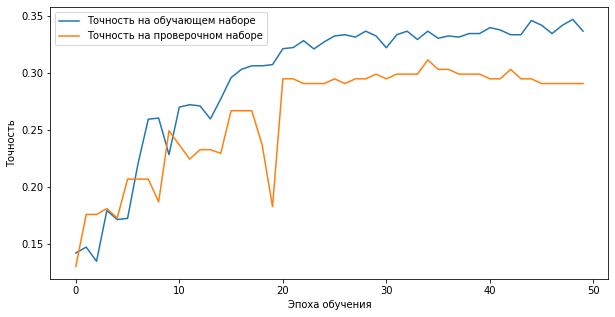

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(data['val_accuracy'], label='Точность на проверочном наборе')
plt.plot(data['accuracy'], label='Точность на обучающем наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Точность')
plt.legend()
plt.show()

ConvLSTM

In [ ]:
model=create_model_ConvLSTM()

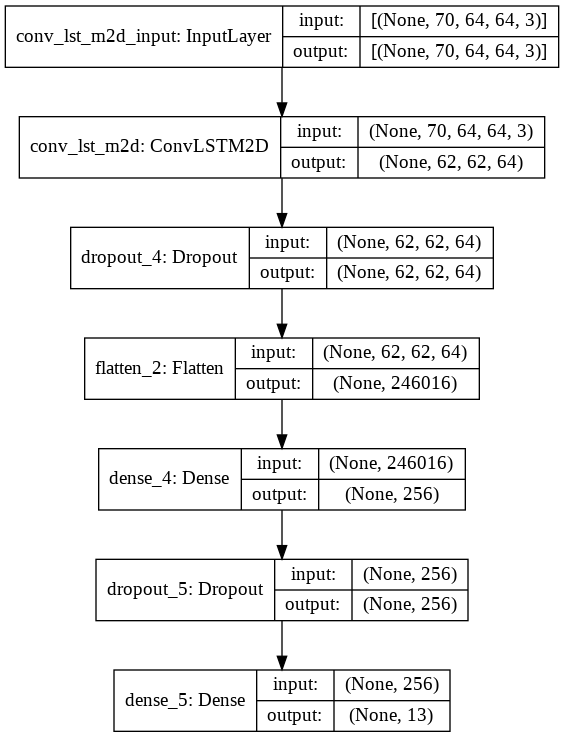

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(x = X_train, y = y_train_oh, epochs=25, batch_size = 8 , shuffle=True, validation_split=0.2,callbacks=callbacks)

In [ ]:
model_path='/content/drive/MyDrive/Colab Notebooks/model/convlstm.h5'

In [ ]:
model.save(model_path)

In [ ]:
your_history_path='/content/drive/MyDrive/Colab Notebooks/model/convlstm.json'

In [ ]:
import json
history_dict = history.history
json.dump(history_dict, open(your_history_path, 'w'))

In [ ]:
with open(your_history_path) as json_file:
    data = json.load(json_file)

In [ ]:
model=keras.models.load_model(model_path)

In [3]:
preds=model.predict(X_test)
results1=[]
for row in preds:
  results1.append(np.argmax(row))
from sklearn.metrics import accuracy_score
accuracy_score(y_test, results1)

0.33672199547290804

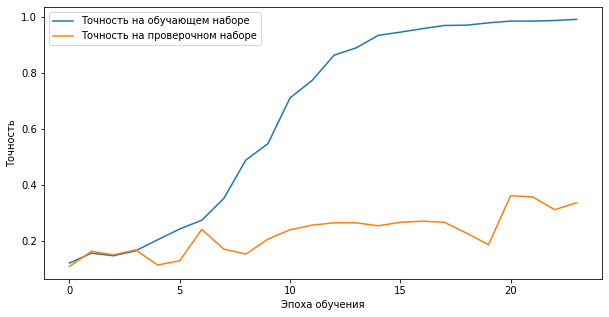

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(data['val_accuracy'], label='Точность на проверочном наборе')
plt.plot(data['accuracy'], label='Точность на обучающем наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Точность')
plt.legend()
plt.show())